# Scalability

Run some experiments for various number of agents $N$.

In [14]:
import csv
import os
import pathlib
import json
import pickle
from pprint import pprint
import string

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline

import numpy as np
import pandas as pd

import seaborn as sns
sns.set_theme(
    context="paper",
    style="whitegrid",
    font_scale=3,
    rc={
        'lines.linewidth': 2,
#         'xtick.bottom': True,
#         'ytick.left': True,
        'axes.grid': True,
        'axes.grid.axis': 'both',
        'axes.grid.which': 'both'
    }
)

In [15]:
# Use latex for exporting
# mpl.use("pgf")  # can specify this as an argument to savefig() each time
mpl.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

## Results format

Results are stored as subfolders, each with a timestamp (e.g. `res_20220306_155424`),
in a root folder `results`.
`results` also contains a CSV called `timestamps.csv` listing the timestamps of each results folder along with configuration parameters.

Each result subfolder contains `config.json`, which gives the experimental configuration used to run experiments (must match the entry in `timestamps.csv`), and `results.json` which contains the collected data.

Each `results.json` contains a list of $N$ 2-tuples, where $N$ is the number of separate runs (each with a different random seed).
Each tuple contains the training and evaluation data respectively, each being a dictionary.
Each of these dicts are in the following key-value format: `metric : list of values over episodes` 

## Load Data

In [3]:
# Location of root folder containing all result subfolders
RESULTS_PATH = pathlib.Path(f"../results-scale/results/")

# Names of metrics in each result folder
METRIC_NAMES = [
    'average_reward',
    'success_rate',
    'average_trust_rate',
    'mutual_trust_rate',
    'average_trust_accuracy'
]

# Convert metric names (lower case, joined by underscores) to human-readable (capitalised with spaces)
METRIC_TO_LABEL = {
    'average_reward': 'Reward',
    'average_trust_accuracy': 'Trust Accuracy',
    'average_trust_rate': 'Trust Rate',
    'mutual_trust_rate': 'Mutual Trust',
    'success_rate': 'Success Rate'
}

# Similarly, variable to human readable
VAR_TO_LABEL = {
    "noise": "$1 - p$",  # "Noise"
    "frac_reliable": "$f$", # "Reliable Fraction",
    "num_processes": "$N$",  # Number of Agents
    "num_processes_sqrt": "$\sqrt{N}$",  # Number of Agents
}

RUNMODE_TO_LABEL = {
    "trained": "RLTC",
    "oracle": "Oracle",
    "trust_all" : "Trust All"
}

RUNMODES = list(RUNMODE_TO_LABEL.keys())

In [4]:
# Collect data from 
all_data = []

for path in RESULTS_PATH.iterdir():
    if not path.name.startswith("res_"):
        continue
    
    timestamp = path.name
    files = {file.name for file in path.iterdir()}
    assert files == {"config.json", "results.json"}
    
    with open(path.joinpath("config.json"), "r") as f:
        config = json.load(f)
    
    with open(path.joinpath("results.json"), "r") as f:
        results = json.load(f)
    
    row = config.copy()
    row["timestamp"] = timestamp
    row["results"] = results
    
    all_data.append(row)

In [5]:
# Basic sanity check
assert len(set(row["timestamp"] for row in all_data)) == len(all_data)
# assert all(all_data[0].keys() == row.keys() for row in all_data)

COLUMN_NAMES = list(sorted(all_data[0].keys()))

df_main = pd.DataFrame(all_data)
df_main.head(3)

,num_processes,frac_reliable,noise,episode_length,run_mode,step_size,discount,epsilon,epsilon_decay_factor,num_train_episodes,num_eval_episodes,unreliable_behaviour,timestamp,results
0,64,0.75,0.3,30,trust_all,0.03,0.999,0.3,0.9996,20000,2000,fixed,res_20220426_144750053066_2,"[[{'average_reward': [], 'success_rate': [], '..."
1,49,0.75,0.3,30,oracle,0.03,0.999,0.3,0.9996,20000,2000,NaN,res_20220422_113345988481_7,"[[{'average_reward': [], 'success_rate': [], '..."
2,100,0.75,0.3,30,trained,0.03,0.999,0.3,0.9996,20000,2000,fixed,res_20220426_230510070928_6,"[[{'average_reward': [-28.21333333333333, -29...."


In [6]:
def extract(row, metric):
    """Extract evaluation results for a particular metric."""
        
    results = row["results"]
    
    # all_train_results = []
    all_eval_results = []
    
    for train_result, eval_result in results:
        # all_train_results.append(train_result)
        all_eval_results.append(eval_result)
    
    return [item[metric] for item in all_eval_results]

# For each metric, get the raw data using extract(), then replace with averages
for metric in METRIC_NAMES:
    df_main[metric] = df_main.apply(lambda x: extract(x, metric), axis=1)
    df_main[metric] = df_main[metric].apply(lambda xs: [np.mean(x) for x in xs])

In [7]:
# For scalability plots only
# Communication graphs are square, so take the square root of number of agents N
df_main["num_processes_sqrt"] = np.sqrt(df_main["num_processes"]).astype(int)
assert ((df_main["num_processes_sqrt"] * df_main["num_processes_sqrt"]) == df_main["num_processes"]).all()

In [8]:
# Show results
# (excluding the original "results" column makes displaying faster)
df_main[df_main.columns.difference(["results"])]

,average_reward,average_trust_accuracy,average_trust_rate,discount,episode_length,epsilon,epsilon_decay_factor,frac_reliable,mutual_trust_rate,noise,num_eval_episodes,num_processes,num_processes_sqrt,num_train_episodes,run_mode,step_size,success_rate,timestamp,unreliable_behaviour
0,"[-29.038666666666664, -29.096020833333334, -29...","[22.812500000000004, 22.239583333333318, 22.70...","[30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30....",0.999,30,0.3,0.9996,0.75,"[30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30....",0.3,2000,64,8,20000,trust_all,0.03,"[4.692427083333334, 4.33540625, 4.1461875, 6.0...",res_20220426_144750053066_2,fixed
1,"[-20.07966666666667, -19.200166666666664, -20....","[30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30....","[20.20833333333332, 22.013888888888896, 22.222...",0.999,30,0.3,0.9996,0.75,"[30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30....",0.3,2000,49,7,20000,oracle,0.03,"[21.061944444444446, 20.924291666666665, 21.03...",res_20220422_113345988481_7,NaN
2,"[-28.099493333333335, -27.697533333333332, -26...","[11.483333333333324, 11.938888888888886, 10.86...","[6.332222222222227, 7.561111111111114, 6.18555...",0.999,30,0.3,0.9996,0.75,"[1.2857142857142863, 2.6800000000000006, 2.058...",0.3,2000,100,10,20000,trained,0.03,"[10.347913333333334, 12.947893333333333, 14.27...",res_20220426_230510070928_6,fixed
3,"[-28.598783333333326, -27.97558333333333, -25....","[11.074999999999992, 12.686111111111103, 12.42...","[5.677777777777776, 6.197222222222222, 7.29861...",0.999,30,0.3,0.9996,0.75,"[0.9090909090909097, 3.0897435897435903, 1.782...",0.3,2000,81,9,20000,trained,0.03,"[10.954658333333333, 12.085091666666667, 12.90...",res_20220426_181700227168_3,fixed
4,"[-18.526833333333343, -22.446777777777783, -18...","[30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30....","[22.22222222222222, 21.11111111111111, 22.2222...",0.999,30,0.3,0.9996,0.75,"[30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30....",0.3,2000,25,5,20000,oracle,0.03,"[20.91925, 21.246388888888887, 21.096666666666...",res_20220422_072730526870_1,NaN
5,"[-26.638972222222222, -26.498055555555556, -28...","[12.733796296296301, 11.974537037037036, 8.726...","[7.442129629629632, 7.131944444444445, 5.89814...",0.999,30,0.3,0.9996,0.75,"[2.790697674418607, 2.260869565217392, 1.38297...",0.3,2000,49,7,20000,trained,0.03,"[12.663361111111112, 12.318402777777777, 12.18...",res_20220422_112606106255_6,NaN
6,"[-23.080566666666666, -22.657416666666663, -18...","[30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30....","[21.374999999999996, 21.708333333333332, 22.20...",0.999,30,0.3,0.9996,0.75,"[30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30....",0.3,2000,81,9,20000,oracle,0.03,"[21.107899999999997, 20.850625, 21.009625, 21....",res_20220426_182926825346_4,fixed
7,"[-29.603666666666665, -29.591777777777775, -29...","[22.870370370370367, 21.851851851851855, 22.12...","[30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30....",0.999,30,0.3,0.9996,0.75,"[30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30....",0.3,2000,36,6,20000,trust_all,0.03,"[4.116296296296295, 3.7342222222222223, 3.9435...",res_20220422_091807787228_5,NaN
8,"[-29.233527777777777, -29.202083333333334, -29...","[20.20833333333332, 22.013888888888896, 22.222...","[30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30....",0.999,30,0.3,0.9996,0.75,"[30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30....",0.3,2000,49,7,20000,trust_all,0.03,"[4.414180555555554, 4.1046805555555546, 3.9980...",res_20220422_114121664885_8,NaN
9,"[-27.250333333333337, -28.038833333333336, -26...","[8.976851851851851, 11.680555555555552, 14.064...","[5.856481481481482, 5.449074074074074, 7.73148...",0.999,30,0.3,0.9996,0.75,"[0.7142857142857146, 1.3000000000000005, 2.619...",0.3,2000,25,5,20000,trained,0.03,"[11.56125, 10.15288888888889, 12.5673888888888...",res_20220422_072345055556_0,NaN


In [9]:
# Delete unused results column
del df_main["results"]

## Plot Data

In [10]:
# Don't include rewards for now (so we get a 4-column grid)
# metric_names = [name for name in METRIC_NAMES if name != "average_reward"]
metric_names = ["success_rate"]
# assert len(metric_names) == 4

# Get the episode length (should be the same across all results)
episode_lengths = pd.unique(df_main["episode_length"])
assert len(episode_lengths) == 1
EPISODE_LENGTH = episode_lengths[0]
print(EPISODE_LENGTH)

30


In [67]:
def plot_metrics(df, metric_names, x_var="noise", control_var="frac_reliable", groupby_var="run_mode"):
    """Plot metrics in a grid.
    
    df: pandas dataframe to use
    metric_names: list of metrics labels to plot
    x_var: variable to hold constant (goes on the x axis per plot)
    control_var: control variable (fixed value per column)
    groupby_var: plot separate lines for each group, default run_mode (trained, oracle, trust_all)
    
    y_var is the metric by default, one metric per row.
    
    In the experiments, we varied both noise and frac_reliable.
    For this plot, we vary one (x_var) while keeping the other fixed (control_var).
    """

    # In the experiments, we varied both noise and frac_reliable,
    # so we vary one (X) and fix the other (control).
    control_unique_values = list(df[control_var].unique())
    control_unique_values.sort()
    
    # Manually set the x axis ticks and limits using this
    x_unique_values = list(df[x_var].unique())
    x_value_range = min(x_unique_values), max(x_unique_values)
    
    # For setting y-limits of plot
    # (all metric values `should` be between 0 and 1)
    metric_range = 0.0, 1.0
    
    # For seaborn hue_order/style_order
    groupby_values = list(df[groupby_var].unique())
    groupby_values.sort()

    fig, axs = plt.subplots(
        len(metric_names),
        len(control_unique_values),
        figsize=(5, 4.5),
#         tight_layout=True,
        sharex=True,
        sharey=True,
        squeeze=False,
    )
    fig.subplots_adjust(left=0.0, right=1.0, wspace=0.3, hspace=0.28)

    for i, (axs_row, metric) in enumerate(zip(axs, metric_names)):

        # Expand results list to rows
        df_metric = df[[x_var, groupby_var, control_var, metric]]
        df_metric = df_metric.explode(metric).reset_index(drop=True)

        # Results are summed over timesteps.
        # Divide through to get per-timestep averages
        df_metric[metric] = df_metric[metric].astype("float64") / EPISODE_LENGTH
        
        for j, (ax, control_value) in enumerate(zip(axs_row, control_unique_values)):

            # Extract subset of data that we need from the full set
            df_plot = df_metric[df_metric[control_var] == control_value]        

            # Line plot with error band (1 stddev)
            sns.lineplot(
                ax=ax,
                data=df_plot,
                x=x_var,
                y=metric,
                hue=groupby_var,
                hue_order=groupby_values,
                ci="sd",
                style=groupby_var,
                style_order=groupby_values,
                markers=True,

                # Draw line and dots over the overlapping axis lines
                clip_on=False,
                zorder=100,
                linewidth=3.0,
                markersize=12.0
            )

            # Metric is shared across the row, so we just show y label for the first column.
            # Also convert y label to its human-readable name
            if j == 0:
                ax.set_ylabel(METRIC_TO_LABEL[metric], labelpad=10)

            # Make the column title frac_reliable (human readable)
#             if i == 0:
#                 ax.set_title("{} $= {}$".format(VAR_TO_LABEL[control_var], control_value))

            # Remove X label, because it is shared across subplots.
            # A supxlabel will be used instead
            ax.set_xlabel(None)
            
            # Remove y labels except first column
            if j > 0:
                ax.set_ylabel(None)

            # Remove legend (show a global one once)
            ax.legend([],[], frameon=False)

            # Avoid plotting beyond value ranges
            ax.set_xlim(x_value_range)
            ax.set_ylim(metric_range)

            # Set axis tickers
            ax.set_xticks(x_unique_values)
            ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.2))
            ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
            
            # Major and minor gridlines
            ax.grid(visible=True, which='major', linewidth=1.0)
            ax.grid(visible=True, which='minor', linewidth=0.5)
            
            # Padding between tick labels and plot
            ax.xaxis.set_tick_params(pad=0.1)
            ax.yaxis.set_tick_params(pad=0.1)
            
    # Global legend
    handles, labels = ax.get_legend_handles_labels()

    # Manually convert legend to human-readable name
    for i in range(len(labels)):
        labels[i] = RUNMODE_TO_LABEL[labels[i]]
    fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.2), prop={"size":18})

    # Reduce the space between plots and this label
    center_x = (fig.subplotpars.left + fig.subplotpars.right) / 2
    fig.supxlabel(VAR_TO_LABEL[x_var], y=-0.05, horizontalalignment='center', x=center_x);
#     fig.suptitle(VAR_TO_LABEL[control_var], y=1.02, horizontalalignment='center', x=center_x)
    
    return fig, axs

### Number of agents vs success rate

Fixed parameters are: $1-p = 0.3$, $f = 0.75$.

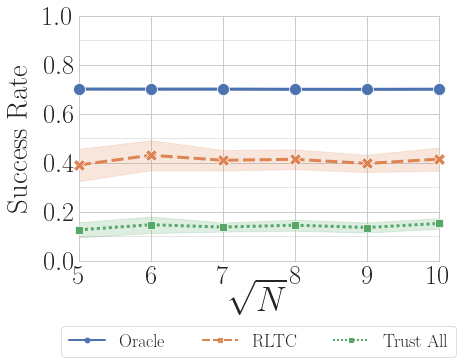

In [68]:
fig, axs = plot_metrics(df_main, ["success_rate"], x_var="num_processes_sqrt", control_var="noise", groupby_var="run_mode");

## Uncomment to save a copy as latex pgf format
fig.set_size_inches(w=5, h=4.5)

# fig.set_tight_layout(True)
fig.savefig(f"out/scalability.pgf", format="pgf", backend="pgf", bbox_inches='tight')